<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/PyTorch_basics%20/basics1-load/Data_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Quality
In this lesson we'll introduce and illusrate the fundamental concept of data quality.

In a nutshell, a machine learning model consumes input data and produces predictions. The quality of the predictions directly corresponds to the quality of data you train the model with; garbage in, garbage out. Check out this article on where it makes sense to use AI and how to properly apply it.

We're going to go through all the concepts with concrete code examples and some synthesized data to train our models on. The task is to determine whether a tumor will be benign (harmless) or malignant (harmful) based on leukocyte (white blood cells) count and blood pressure. This is a synthetic dataset that we created and has no clinical relevance.

In [29]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 

import sys
sys.path.insert(0,'/content')
from idlmam import *

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import json
import matplotlib.pyplot as plt


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)
device = torch.device("cuda")

<ipython-input-29-6ae6b5e67e4f>:28: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,14.338940,15.541530,malignant
1,14.751821,13.618972,benign
2,16.998943,15.296528,benign
3,14.936796,17.024649,malignant
4,15.613526,13.359265,benign


In [4]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1000, 2)
y:  (1000,)


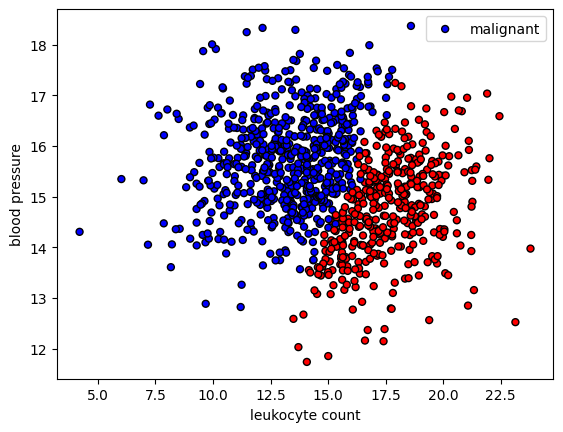

In [5]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()

We want to choose features that have strong predictive signal for our task. If you want to improve performance, you need to continuously do feature engineering by collecting and adding new signals. So you may run into a new feature that has high correlation (orthogonal signal) with your existing features but it may still possess some unique signal to boost your predictive performance.

<ipython-input-6-c391c1087a5c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,leukocyte_count,blood_pressure
leukocyte_count,1.000000,-0.162875
blood_pressure,-0.162875,1.000000


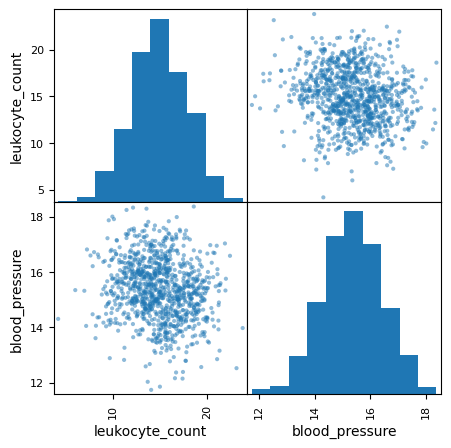

In [6]:
# Correlation matrix
scatter_matrix(df, figsize=(5, 5));
df.corr()

#Split data

In [7]:
import collections
from sklearn.model_selection import train_test_split

In [8]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [9]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [ 9.52007142 14.86279169] → malignant


#Label encoding

In [12]:
# Output vectorizer
label_encoder = LabelEncoder()

# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['benign', 'malignant']


In [13]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: malignant
y_train[0]: 1


In [14]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


# Standardize data

In [16]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [17]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [18]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.0, std: 0.9
X_test[1]: mean: -0.1, std: 1.1


#Model

In [19]:
INPUT_DIM = 2 # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = 2

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [21]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>


#Training

In [22]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [23]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [24]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [26]:
from torch.optim import Adam
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [27]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)
     

In [28]:

# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")
     

Epoch: 0 | loss: 0.66, accuracy: 73.0
Epoch: 10 | loss: 0.52, accuracy: 92.7
Epoch: 20 | loss: 0.41, accuracy: 94.4
Epoch: 30 | loss: 0.34, accuracy: 96.0
Epoch: 40 | loss: 0.29, accuracy: 96.9


#Evaluation

In [30]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [31]:
# Predictions
y_prob = model(X_test, apply_softmax=True)
y_pred = y_prob.max(dim=1)[1]
     


In [32]:
# Performance
performance = get_performance(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))
     

{
  "overall": {
    "precision": 0.96375,
    "recall": 0.96,
    "f1": 0.9603094492540062,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.90625,
      "recall": 1.0,
      "f1": 0.9508196721311475,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 1.0,
      "recall": 0.9347826086956522,
      "f1": 0.9662921348314606,
      "num_samples": 92.0
    }
  }
}


In [33]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

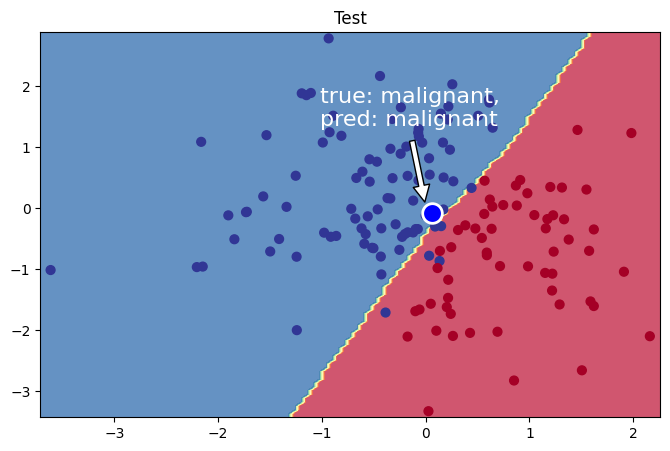

In [34]:
# Visualize the decision boundary
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary
mean_leukocyte_count, mean_blood_pressure = X_scaler.transform(
    [[np.mean(df.leukocyte_count), np.mean(df.blood_pressure)]])[0]
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200, 
            c="b", edgecolor="w", linewidth=2)

# Annotate
plt.annotate("true: malignant,\npred: malignant",
             color="white",
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.4, 0.65),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor="white", shrink=0.1))
plt.show()